# Learning Objectives of the LSTM tutorial:
* Build a simple LSTM 
* Become familiar with PyTorch
* Train models using GPU
* Use cloud hosted data (via AWS S3 -  streamflow-app-data bucket)


In [1]:
#basic packages
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

#modeling packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

#Modeling scripts from scripts folder
from scripts.dataprocessing import readdata, create_lookback_univariate
from scripts.LSTM import Simple_LSTM, train_LSTM, LSTM_load
from scripts.evaluation import plot, model_eval

#See if you system is using GPU (cuda) or cpu. We want to run on cpu if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


## Making a real model!
This tutorial will use USGS NWIS 10155000 in Charelston, UT to demonstrate the development of a real world modeling pipeline.
We will:
* load the daily streamflow from the CIROH AWS S3 streamflow-app-data bucket in .parquet format
* process it for use in the LSTM
* use a prebuilt LSTM from [LSTM.py](/scripts/LSTM.py) to train, test, and evaluate the model

![site](Images/10155000site.JPG)

Using the [Community Streamflow Evaluation System (CSES)](http://portal.ciroh.org/t/apps/community-streamflow-evaluation-system/huc_eval/?), we find that the NWM NHDPlus id for this USGS location is 10375648.

In [12]:
#read parquet file from AWS s3 - put in credentials or updated script to not need them
folder = 'RJ/data'
USGSpath = f"{folder}/GSL_NWM_NWIS_dataset.parquet"

df = readdata(USGSpath, drop = True)

#change column name for USGS flow
df.rename(columns={'flow_cfs': 'USGS_flow'}, inplace= True)

#select our site of interest
NWISsite = 10155000
df = df[df['station_id'] == NWISsite]

#selecting columns for use as features into the model
cols = ['datetime', 'USGS_flow']
df=df[cols]

#convert datetime to pandas datetime dtype
df['datetime'] =pd.to_datetime(df['datetime'])

#sort values and set index to date time
df.sort_values(by='datetime', inplace=True)
df.set_index('datetime', inplace=True)

#drop any rows with NaN
df = df.dropna()

df.head(5)

,USGS_flow
datetime,
1986-10-01,144.11765
1986-10-02,147.25000
1986-10-03,154.50000
1986-10-04,144.12500
1986-10-05,142.50000


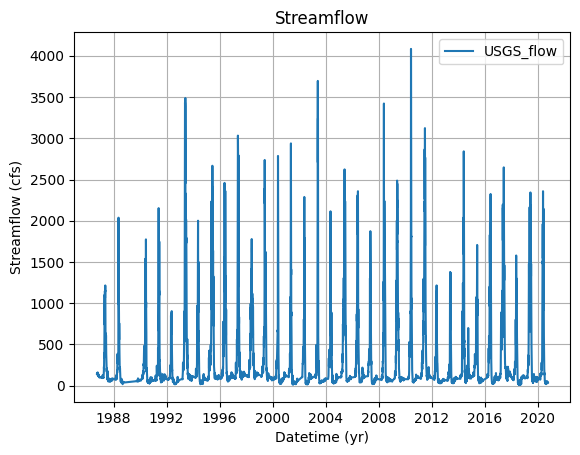

In [13]:
#plot the data
cols = ['USGS_flow']
plot(df, cols)

In [14]:
#define a train/test ratio
train_ratio = 0.67

#split data into train/test - note, for LSTM there is not need to randomize the split
timeseries = df[["USGS_flow"]].values.astype('float32') #conver the df into an array

trainsize = int(len(timeseries)*train_ratio) # 67% of data for training
testsize = len(timeseries)-trainsize # remaining (~33%) data for testing

train, test = timeseries[:trainsize], timeseries[-testsize:]


We typically perform simple time series prediction on a moving window (w), given data from t -w to t, with w governing how much data the model can look back on (i.e., look back period).
On a long timeseries, the developer can create multiple overlapping windows, and it is convienant to create a function to generate a dataset of a fixed window from the time series.
Since we are using PyTorch, we need to convert the dataset into tensors.

The design of the create_tensors() function is to apply windows on the time series in order to predict at timestep t+1, converting the time series into a a tensor of dimensions (window sample, time steps, features). 
A time series of n timesteps can produce approximately n windows (e.g., a window can start at any time step given the window does not exceed the boundaries of the time series). 
Within the window are multiple consecutive time steps of values, and in each time step there can be mutliple features (see [Feature_LSTM](Feature_LSTM.ipynb)).

Data processing steps must produce the features and target into the same shape. 
Example, for a window of 3 timesteps, the features are the time series from t to t+2 and the targets are from t+1 to t+3. 
We are looking to predict for t+3 but the information in t+1 and t+2 is useful for training.
From our create_tensors() function, the input time series is a 2D array and the output will be a 3D tensor.
We call the window the lookback and its setting determines how many previous time steps the model can look back to inform a prediction.
The **lookback** value is a very important value for an LSTM. 
Lets explore.

In [15]:
#set lookback
lookback = 4 #

#create testing and training tensors
X_train, y_train =  create_lookback_univariate(train, lookback = lookback)
X_test, y_test =  create_lookback_univariate(test, lookback = lookback)

trainsize = len(X_train)
testsize = len(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(trainsize, testsize)

torch.Size([6452, 4, 1]) torch.Size([6452, 4, 1])
torch.Size([3176, 4, 1]) torch.Size([3176, 4, 1])
6452 3176


# Build the LSTM
![PyTorchLSTM](Images/PytorchLSTM.JPG)

For more detailed information, please visit the [Pytorch LSTM documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

## Model Set up
We can now build the LSTM model to predict the time series using the Simple_LSTM() class from [Simple_LSTM.py](/scripts/Simple_LSTM.py).

The torch.nn call uses nn.LSTM() that accepts inputsize, hidden_size, num_layers, and batchfirst as inputs, generating a tuple as an output. 
The first element of the tuple is the generate hidden state, one for each time step of the input.
The second element is the LSTM cell  memory adn hidden states which we will not use.

We create an LSTM layer by setting the batchfirst variable to True, which makes use of the input tensors of dimensions (window sample, time steps, features).
The model creates a batch by sampling the first dimension.

The last function in the LSTM is for processing the fully connected LSTM output into a single regression result (e.g., self.linear = nn.Linear()). 
The output of the model will form as an input for the next time step.

We will select MSE as the loss function because we are performing a regression task, which will seek to minimize through the applicaiton of the Adam optimizer.
Below, we load the Simple_LSTM() class and combine with the PyTorch tensors using torch.utils.data.TensorDataset() and batch training provided by DataLoader.
A DataLoader automatically creates minibatches of the dataset for the training process and speeds up the data loading process by parallelizing the loading of data from disc to the GPU/CPU.
[Leaky.ai](https://www.leaky.ai/dataloader) provides additional information how to set up a dataloader
During model training, the model evaluates its performance once per 100 epochs, on both the training and testing datasets.

From this tutorial, we see how the data size (~144 obs, small dataset), batch size, and the number of epoch influence the model training time.

In [16]:
#Inputs and model parameters
input_size = 1 #the number of expected feaures in the input x
hidden_size = 50 # the number of features in the hidden state h
num_layers = 1 #the number of recurrent layers. E.g., setting to 2 means stacking 2 LSTMS together to form a stacked LSTM with the second taking the outputs from the first
batch_size = 100 #Typically set the batch size to loop through 64-128 samples at a time
batchfirst = True #if True, the the input and output tensors are (batch, seq, feature) instead of (seq, batch, feature)
n_epochs = 500 # Make sure there are enough epochs to ensure model convergence, excess epochs will just increase training time. . 
save_model = True
test_score = True
model_path = 'models/Simple_LSTM/best_model.pt'

#Load model class
model = Simple_LSTM(input_size, hidden_size, num_layers, batchfirst)
#connect to GPU device - will default to cpu if there is no GPU available
model.to(device)
# set optimizer
optimizer = optim.Adam(model.parameters())
#set loss function
loss_fn = nn.MSELoss()
#set dataloader function
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

#set configurations dictionary
config_dict = {
            'X_train': X_train, 
            'y_train' : y_train,
            'X_test': X_test,
            'y_test': y_test,
            'n_epochs': n_epochs,
            'model': model, 
            'loader': loader, 
            'optimizer': optimizer, 
            'loss_fn': loss_fn, 
            'save_model': save_model, 
            'model_path': model_path, 
            'test_score': test_score,
}


#Train the LSTM
train_LSTM(config_dict)


Epoch 0: train RMSE 605.5602, test RMSE 575.7090
Epoch 10: train RMSE 586.7280, test RMSE 556.6702
Epoch 20: train RMSE 573.1428, test RMSE 542.9759
Epoch 30: train RMSE 560.9095, test RMSE 530.6870
Epoch 40: train RMSE 549.3751, test RMSE 519.1238
Epoch 50: train RMSE 538.2156, test RMSE 507.9235
Epoch 60: train RMSE 527.3374, test RMSE 496.9799
Epoch 70: train RMSE 516.6761, test RMSE 486.2281
Epoch 80: train RMSE 506.2787, test RMSE 475.7122
Epoch 90: train RMSE 496.0659, test RMSE 465.3471
Epoch 100: train RMSE 486.0661, test RMSE 455.1622
Epoch 110: train RMSE 476.2612, test RMSE 445.1287
Epoch 120: train RMSE 466.6635, test RMSE 435.2845
Epoch 130: train RMSE 457.2085, test RMSE 425.5216
Epoch 140: train RMSE 447.9182, test RMSE 415.9148
Epoch 150: train RMSE 438.8135, test RMSE 406.4884
Epoch 160: train RMSE 429.8522, test RMSE 397.1795
Epoch 170: train RMSE 421.0611, test RMSE 388.0257
Epoch 180: train RMSE 412.4558, test RMSE 379.0476
Epoch 190: train RMSE 404.0092, test RMSE 

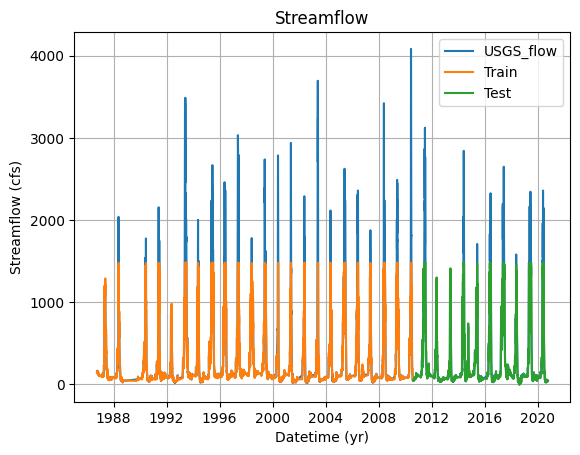

LSTM: NSE 0.8653, RMSE 147.0000, MaxError 1645.0000, MAPE 9.0000, KGE 0.7700 


In [17]:
#Inputs and model parameters to load model
input_size = 1 
hidden_size = 50 
num_layers = 1 
batchfirst = True 
model_path = 'models/Simple_LSTM/best_model.pt'
loss_fn = nn.MSELoss()
cols = ['USGS_flow', 'Train', 'Test']


#load model and make predictions on training and testing datasets
model = Simple_LSTM(input_size, hidden_size, num_layers, batchfirst)
model = LSTM_load(model, model_path)

#Evaluate model
df = model_eval(df, cols, model, lookback, X_train, X_test, train_ratio)

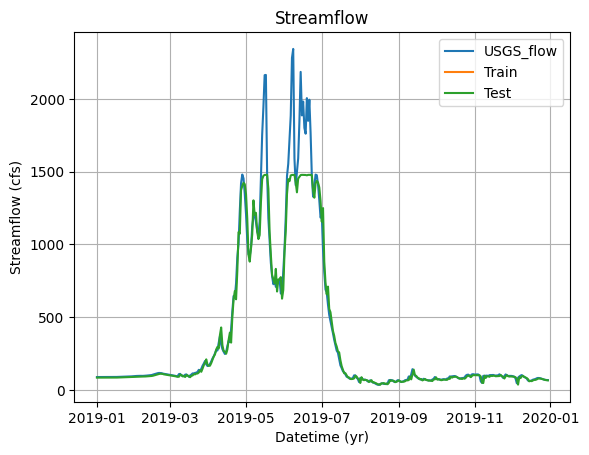

LSTM: NSE 0.9301, RMSE 123.0000, MaxError 866.0000, MAPE 8.0000, KGE 0.8300 


In [18]:
#lets take a closer look at the predictions, its a bit difficult to investigate in the above plot
plot(df.loc['2019-1-1':'2019-12-30'], cols)

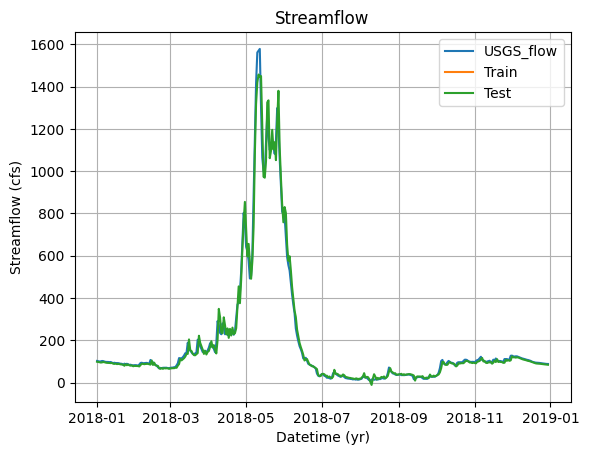

LSTM: NSE 0.9884, RMSE 32.0000, MaxError 177.0000, MAPE 12.0000, KGE 0.9900 


In [19]:
#lets take a closer look at the predictions, its a bit difficult to investigate in the above plot
plot(df.loc['2018-1-1':'2018-12-30'], cols)

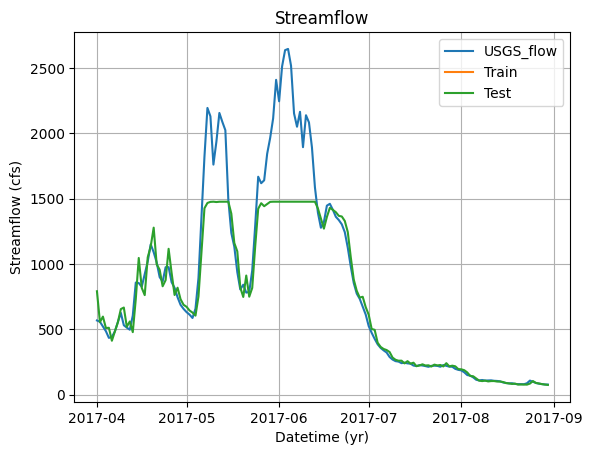

LSTM: NSE 0.6909, RMSE 290.0000, MaxError 1170.0000, MAPE 11.0000, KGE 0.6100 


In [20]:
#lets take a closer look at the predictions, its a bit difficult to investigate in the above plot
plot(df.loc['2017-4-1':'2017-8-30'], cols)

### Next Steps: items to add, after each set of feature, see how to predict streamflow without using any NWIS observations for inputs.
* NWM streamflow can we do NWM to NWIS?
* NWM forcings
* reservoir storage 
* other stream sites
* static catchment attributes